In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load images

In [5]:
folderimages_ER = '/media/andres/disco1tera/ubuntu/Trabajo/Direct-Detection/xenon1t-classifier/data/images/ER/img-128x128-alias/'
folderimages_WP = '/media/andres/disco1tera/ubuntu/Trabajo/Direct-Detection/xenon1t-classifier/data/images/WP-500GeV-sig1e-45/img-128x128-alias/'

model_name = 'saved-models/03_model_CNN_128x128_500GeV_alias.h5'
model_paper = 'paper-model/final_model.h5'

In [6]:
from keras import backend as K
np.random.seed(0)

# Define recall, precision and f1 functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##### TEST-VAL SET

In [7]:
# test
from PIL import Image

for i in range(2):
    img = Image.open( folderimages_WP+'WP' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print(data.shape)
    
for i in range(2):
    img = Image.open( folderimages_ER+'ER' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print(data.shape)

(128, 128, 4)
(128, 128, 4)
(128, 128, 4)
(128, 128, 4)


In [8]:
##########
# SIGNAL #
##########
num_signal = 10000

file_pathsWP = glob.glob(path.join(folderimages_WP, 'WP*.png'))

# Load the images into a single variable and convert to a numpy array
imagesWP = [imageio.imread(file_pathsWP[jj]) for jj in range(num_signal)]
imagesWP = np.asarray(imagesWP)

labelsWP = np.ones(num_signal)


##############
# BACKGROUND #
##############
num_back = 10000

file_pathsER = glob.glob(path.join(folderimages_ER, 'ER*.png'))

# Load the images into a single variable and convert to a numpy array
imagesER = [imageio.imread(file_pathsER[jj]) for jj in range(num_back)]
imagesER = np.asarray(imagesER)

labelsER = np.zeros(num_back)



images = np.concatenate([imagesWP,imagesER])
del imagesWP
del imagesER

labels = np.concatenate([labelsWP,labelsER])
del labelsWP
del labelsER



print('images.shape: ', images.shape)
print('labels.shape: ', labels.shape)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

# Scale images so values are between 0 and 1
images = images / 255

n_images = images.shape[0]

images.shape:  (20000, 128, 128, 4)
labels.shape:  (20000,)
[128 128   4]


In [9]:
sum(labels)

10000.0

In [10]:
labels.shape

(20000,)

In [11]:
# Split into test and training sets

TRAIN_TEST_SPLIT = 0.7            

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_val = images[test_indices, :, :, :]
y_val = labels[test_indices]

#x_train = images
#y_train = labels

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(14000, 128, 128, 4)
(14000,)
(6000, 128, 128, 4)
(6000,)


##### TRAIN THE MODEL

In [12]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (image_size[0], image_size[1], image_size[2])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(x_train, y_train, epochs=50, batch_size=100, verbose=1, validation_data=(x_val, y_val))
    model.save(model_name)
    #model.save_weights('final_weights.h5')
    score = model.evaluate(x_val, y_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
140/140 [==============================] - 55s 317ms/step - loss: 3.8859 - acc: 0.5272 - f1_m: 0.4853 - precision_m: 0.5035 - recall_m: 0.4959 - val_loss: 0.7178 - val_acc: 0.7492 - val_f1_m: 0.7546 - val_precision_m: 0.7438 - val_recall_m: 0.7702
Epoch 2/50
140/140 [==============================] - 43s 311ms/step - loss: 0.7761 - acc: 0.6810 - f1_m: 0.6814 - precision_m: 0.6786 - recall_m: 0.6976 - val_loss: 0.6630 - val_acc: 0.7567 - val_f1_m: 0.7617 - val_precision_m: 0.7526 - val_recall_m: 0.7755
Epoch 3/50
140/140 [==============================] - 44s 311ms/step - loss: 0.6803 - acc: 0.7426 - f1_m: 0.7391 - precision_m: 0.7552 - recall_m: 0.7301 - val_loss: 0.6171 - val_acc: 0.7625 - val_f1_m: 0.7445 - val_precision_m: 0.8145 - val_recall_m: 0.6905
Epoch 4/50
140/140 [==============================] - 44s 316ms/step - loss: 0.6282 - acc: 0.7730 - f1_m: 0.7709 - precision_m: 0.7758 - recall_m: 0.7733 - val_loss: 0.5808 - val_acc: 0.7943 - val_f1_m: 0.7976 - val_precisi

140/140 [==============================] - 43s 306ms/step - loss: 0.5224 - acc: 0.8277 - f1_m: 0.8284 - precision_m: 0.8174 - recall_m: 0.8451 - val_loss: 0.5096 - val_acc: 0.8318 - val_f1_m: 0.8319 - val_precision_m: 0.8378 - val_recall_m: 0.8293
Epoch 33/50
140/140 [==============================] - 43s 304ms/step - loss: 0.5277 - acc: 0.8212 - f1_m: 0.8247 - precision_m: 0.8132 - recall_m: 0.8434 - val_loss: 0.5371 - val_acc: 0.8228 - val_f1_m: 0.8263 - val_precision_m: 0.8143 - val_recall_m: 0.8416
Epoch 34/50
140/140 [==============================] - 43s 305ms/step - loss: 0.5358 - acc: 0.8211 - f1_m: 0.8215 - precision_m: 0.8126 - recall_m: 0.8377 - val_loss: 0.5352 - val_acc: 0.8217 - val_f1_m: 0.8262 - val_precision_m: 0.8119 - val_recall_m: 0.8439
Epoch 35/50
140/140 [==============================] - 43s 305ms/step - loss: 0.5470 - acc: 0.8219 - f1_m: 0.8242 - precision_m: 0.8158 - recall_m: 0.8404 - val_loss: 0.5155 - val_acc: 0.8327 - val_f1_m: 0.8363 - val_precision_m: 0.

##### Test with the validation set (just to see)

In [13]:
##################################
# USING TO TEST THE TRAINING SET # THIS IS WRONG! but to see
##################################

x_test2 = x_val
y_test2 = y_val

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      592       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                8000032   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

/home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Logistic: f1=0.779 auc=0.9031552


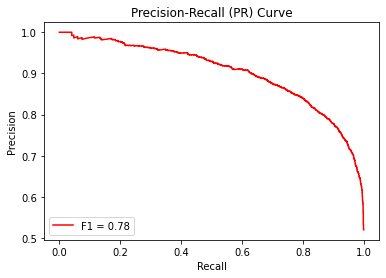

Accuracy: 0.7986666666666666
Average precision: 0.7642557972546024
recall: 0.7026402640264027
AUC:0.8633903290575363
Predicted   0.0   1.0
Actual               
0.0        2663   307
1.0         901  2129


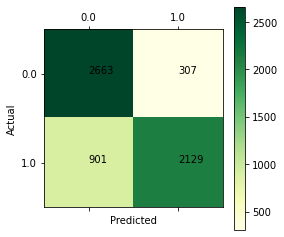

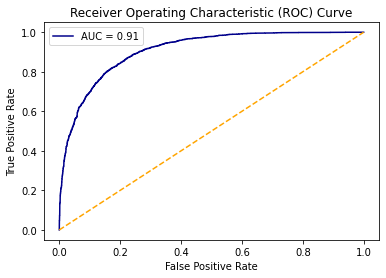

ROC AUC:  0.9075319198586526


In [14]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_name, custom_objects=dependencies)

model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])

model.summary()



score = model.evaluate(x_test2, y_test2, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test2)    # Predict probabilities
yhat = model.predict(x_test2)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test2, lr_probs)
lr_f1, lr_auc = f1_score(y_test2, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test2[y_test2==1]) / len(y_test2)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test2, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test2, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test2, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test2, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test2.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test2, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

In [21]:
###############
# PAPER MODEL #
###############

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_paper, custom_objects=dependencies)

model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])

model.summary()


from sklearn.metrics import roc_curve, roc_auc_score, auc

yhat2 = model.predict(x_test2)      # Predict class values
fpr, tpr, thresholds = roc_curve(y_test2, yhat2)
auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 72, 72, 16)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32)              

ValueError: in user code:

    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1544 predict_function  *
        return step_function(self, iterator)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1527 run_step  *
        outputs = model.predict_step(data)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1500 predict_step  *
        return self(x, training=False)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:375 call  *
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:416 call  *
        inputs, training=training, mask=mask)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:551 _run_internal_graph  *
        outputs = node.layer(*args, **kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:248 assert_input_compatibility  *
        raise ValueError(

    ValueError: Input 0 of layer dense_35 is incompatible with the layer: expected axis -1 of input shape to have value 82944 but received input with shape (None, 250000)


##### Test with the train set (just to see)

In [15]:
##################################
# USING TO TEST THE TRAINING SET # THIS IS WRONG! but to see
##################################

x_test2 = images
del images

y_test2 = labels
del labels

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      592       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                8000032   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

/home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Logistic: f1=0.802 auc=0.9210110


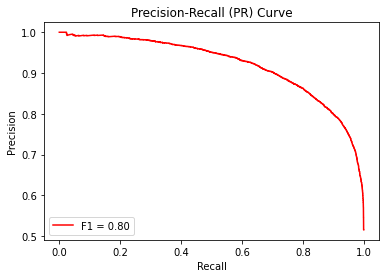

Accuracy: 0.8198
Average precision: 0.7846524274213222
recall: 0.7297
AUC:0.8774725725786778
Predicted   0.0   1.0
Actual               
0.0        9099   901
1.0        2703  7297


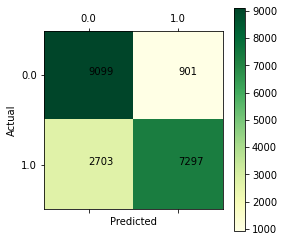

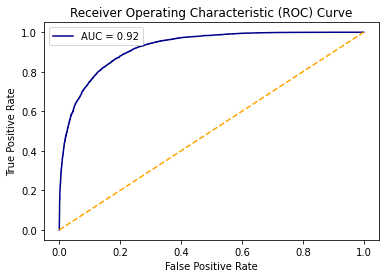

ROC AUC:  0.924170945


In [16]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_name, custom_objects=dependencies)

model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])

model.summary()



score = model.evaluate(x_test2, y_test2, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test2)    # Predict probabilities
yhat = model.predict(x_test2)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test2, lr_probs)
lr_f1, lr_auc = f1_score(y_test2, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test2[y_test2==1]) / len(y_test2)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test2, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test2, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test2, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test2, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test2.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test2, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

In [39]:
###############
# PAPER MODEL #
###############

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_paper, custom_objects=dependencies)

model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])

model.summary()

from sklearn.metrics import roc_curve, roc_auc_score, auc

yhat2 = model.predict(x_test2)      # Predict class values
fpr, tpr, thresholds = roc_curve(y_test2, yhat2)
auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 72, 72, 16)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32)              

ValueError: in user code:

    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:420 call
        return self._run_internal_graph(
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/andres/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_35 is incompatible with the layer: expected axis -1 of input shape to have value 82944 but received input with shape (None, 250000)


##### TESTSET

In [17]:
##########
# SIGNAL #
##########
num_signal_test = 5000

file_pathsWP = glob.glob(path.join(folderimages_WP, 'WP*.png'))

# Load the images into a single variable and convert to a numpy array
imagesWP = [imageio.imread(file_pathsWP[jj]) for jj in range(num_signal,num_signal+num_signal_test)]
imagesWP = np.asarray(imagesWP)

labelsWP = np.ones(num_signal_test)


##############
# BACKGROUND #
##############
num_back_test = 5000

file_pathsER = glob.glob(path.join(folderimages_ER, 'ER*.png'))

# Load the images into a single variable and convert to a numpy array
imagesER = [imageio.imread(file_pathsER[jj]) for jj in range(num_back,num_back+num_back_test)]
imagesER = np.asarray(imagesER)

labelsER = np.zeros(num_back_test)



images_test = np.concatenate([imagesWP,imagesER])
del imagesWP
del imagesER

labels_test = np.concatenate([labelsWP,labelsER])
del labelsWP
del labelsER


print('images_test.shape: ', images_test.shape)
print('labels_test.shape: ', labels_test.shape)

# Get image size
image_size_test = np.asarray([images_test.shape[1], images_test.shape[2], images_test.shape[3]])
print(image_size_test)

# Scale images so values are between 0 and 1
images_test = images_test / 255

n_images_test = images_test.shape[0]



x_test = images_test
del images_test

y_test = labels_test
del labels_test

images_test.shape:  (10000, 128, 128, 4)
labels_test.shape:  (10000,)
[128 128   4]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      592       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                8000032   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0

/home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Logistic: f1=0.785 auc=0.9050921


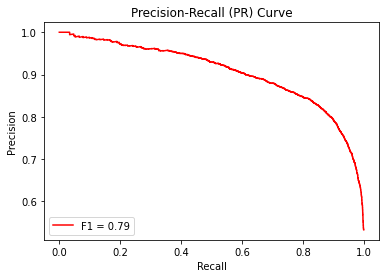

Accuracy: 0.8054
Average precision: 0.7677334977799704
recall: 0.7108
AUC:0.8660325111001479
Predicted   0.0   1.0
Actual               
0.0        4500   500
1.0        1446  3554


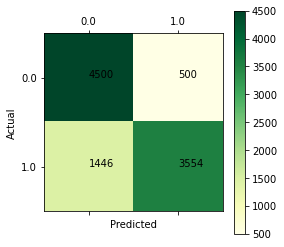

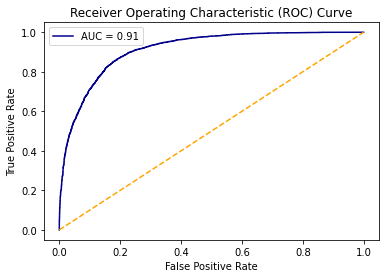

ROC AUC:  0.9121650800000001


In [18]:
##########################
# TEST WITH THE TEST SET #
##########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_name, custom_objects=dependencies)

model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])

model.summary()



score = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict_proba(x_test)    # Predict probabilities
yhat = model.predict(x_test)      # Predict class values
yhat_original = yhat
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test, yhat_original)
auc = auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

In [18]:
###############
# PAPER MODEL #
###############

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model(model_paper, custom_objects=dependencies)

model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])

model.summary()


from sklearn.metrics import roc_curve, roc_auc_score, auc

yhat = model.predict(x_test)      # Predict class values
fpr, tpr, thresholds = roc_curve(y_test, yhat)
auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr)

print('ROC AUC: ', auc)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 73, 73, 16)        592       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 72, 72, 16)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 72, 72, 16)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2654240   
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32)              

ValueError: in user code:

    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1544 predict_function  *
        return step_function(self, iterator)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1527 run_step  *
        outputs = model.predict_step(data)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1500 predict_step  *
        return self(x, training=False)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:375 call  *
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:416 call  *
        inputs, training=training, mask=mask)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:551 _run_internal_graph  *
        outputs = node.layer(*args, **kwargs)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/andres/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:248 assert_input_compatibility  *
        raise ValueError(

    ValueError: Input 0 of layer dense_35 is incompatible with the layer: expected axis -1 of input shape to have value 82944 but received input with shape (None, 250000)
